In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_csv('./data/train.csv', sep=';')
columns = data.columns

In [5]:
data.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


In [6]:
def normalise(curve, ref_low, ref_high, well_low, well_high):
    
    norm = ref_low + ((ref_high - ref_low) * ((curve - well_low) / (well_high - well_low)))
    return norm

KeyboardInterrupt: 

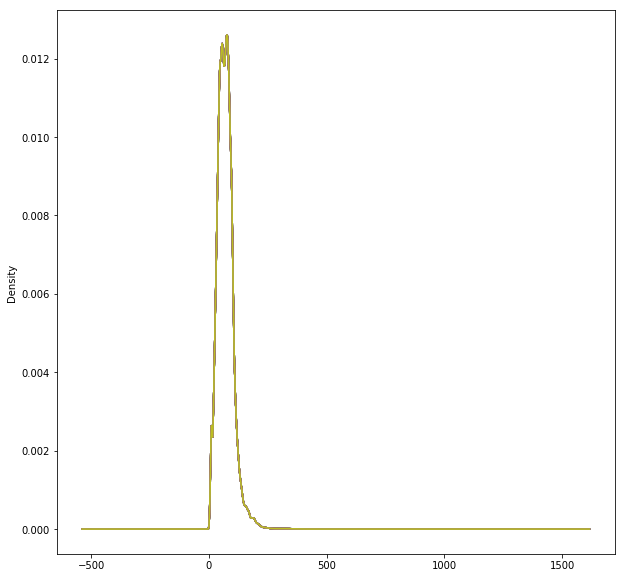

In [8]:
fig,ax = plt.subplots(figsize=(10,10))

well_gr_groups = data.groupby('WELL')

for name, well in well_gr_groups:
    data.GR.plot(kind='kde', ax=ax)

plt.xlim(0, 300)
plt.show()